## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 5: **

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [1]:
chapter = "chapter5/"
img_path = "img/content/"+chapter

In [2]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import odeint
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as Cte

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de kerKKF
from kkf.DynamicalSystems import DynamicalSystem
from kkf.kEDMD import KoopmanOperator
import kkf.applyKKF as kkf

# Paralelización
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Pandas
import pandas as pd

# Para medir el tiempo
from time import time

# Dependencias de PyMC 
import arviz as az
import pymc as pm
import pytensor
from pymc.ode import DifferentialEquation
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

In [3]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'figure.figsize': (14, 8)})
plt.rcParams.update({'figure.titlesize': 24})

In [4]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

In [5]:
# Se fija la semilla aleatoria
np.random.seed(42)

In [6]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [7]:
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

In [8]:
theta = np.array([0.1, 0.1])  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    beta_ = pm.TruncatedNormal("beta", mu=theta[0], sigma=0.01, lower=0, initval=theta[0])
    gamma_ = pm.TruncatedNormal("gamma", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)

In [ ]:
vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 10000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=4)
met_time = time() - met_time
trace = trace_DEMZ
az.summary(trace)

Multiprocess sampling (8 chains in 4 jobs)
DEMetropolisZ: [beta, gamma]


/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/var/folders/rf/jjf6nprx39345csg42dq8wbr0000gn/T/ipykernel_46891/4130135104.py:7: RuntimeWarning: overflow encountered in scalar multiply
  -beta*S*I,
/var/folders/rf/jjf6nprx39345csg42dq8wbr0000gn/T/ipykernel_46891/4130135104.py:8: RuntimeWarning: overflow encountered in scalar 

Sampling 8 chains for 10_000 tune and 10_000 draw iterations (80_000 + 80_000 draws total) took 59 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.905,0.058,0.797,1.012,0.001,0.0,7192.0,9743.0,1.0
gamma,0.332,0.032,0.274,0.395,0.000,0.0,6221.0,10298.0,1.0


In [37]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 59.59 s


In [1]:
beta_trace = trace.posterior["beta"].shape
gamma_trace = trace.posterior["gamma"].shape

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'DMetropolis_sir_params_density.pdf')

NameError: name 'trace' is not defined

### SIR con pérdida de inmunidad

In [44]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    alpha_, beta_, gamma_ = theta
    x_, y_ = np.zeros((nx, iters)), np.zeros((ny, iters))
    x_[:, 0] = x0

    for i in range(1, iters):
        x_[:, i] = f(x_[:, i-1], alpha_, beta_, gamma_)
        y_[:, i] = g(x_[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    return y_

theta = np.array([0.1, 0.1, 0.1])  
with pm.Model() as model:
    # Priors
    alpha_ = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.01, lower=0, initval=theta[0])
    beta_ = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma_ = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.01, lower=0, initval=theta[2])

    # Ode solution function
    y_ = pytensor_forward_model_matrix(
        pm.math.stack([alpha_, beta_, gamma_])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=y_, sigma=0.01, observed=y)
vars_list = list(model.values_to_rvs.keys())[:-1]

# MCMC con Metropolis
tune = draws = 15000
met_time = time()
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=8, cores=4)
met_time = time() - met_time

Multiprocess sampling (8 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, gamma]


/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/var/folders/rf/jjf6nprx39345csg42dq8wbr0000gn/T/ipykernel_46891/354121061.py:7: RuntimeWarning: overflow encountered in scalar multiply
  alpha*R-beta*S*I,
/var/folders/rf/jjf6nprx39345csg42dq8wbr0000gn/T/ipykernel_46891/354121061.py:8: RuntimeWarning: overflow encountered in sc

Sampling 8 chains for 15_000 tune and 15_000 draw iterations (120_000 + 120_000 draws total) took 93 seconds.


In [ ]:
trace = trace_DEMZ
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.109,0.035,0.045,0.177,0.000,0.000,5604.0,5910.0,1.0
beta,0.742,0.083,0.584,0.895,0.001,0.001,6128.0,7490.0,1.0
gamma,0.324,0.034,0.259,0.386,0.000,0.000,6906.0,10081.0,1.0


In [46]:
print(f"Tiempo de ejecución: {met_time:.2f} s")

Tiempo de ejecución: 93.26 s


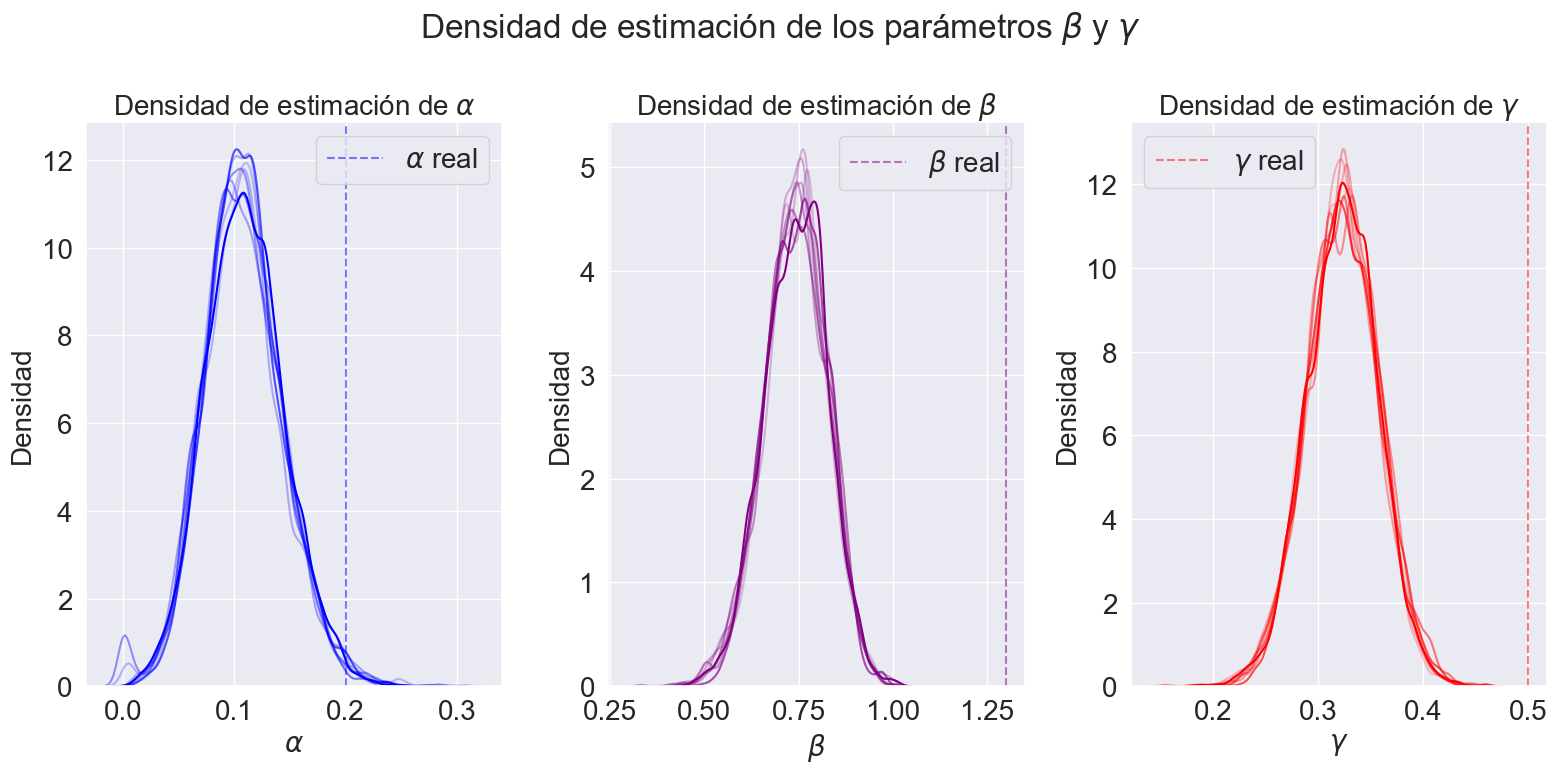

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["alpha"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'DMetropolis_sir_rec_params_density.pdf')

In [ ]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [54]:
def rhs_pymcode(y, t, p):
    dS_dt = -p[0]*y[0]*y[1]
    dI_dt = p[0]*y[0]*y[1] - p[1]*y[1]
    dR_dt = p[1]*y[1]
    return [dS_dt, dI_dt, dR_dt]

In [56]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=2, t0=0
)

In [59]:
with pm.Model() as model:
    # Priors
    beta = pm.TruncatedNormal("beta", mu=theta[0], sigma=0.01, lower=0, initval=theta[0])
    gamma = pm.TruncatedNormal("gamma", mu=theta[1], sigma=0.1, lower=0, initval=theta[1])
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=y.T)

In [ ]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 10
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8)
time_nuts = time() - time_nuts

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, gamma]


/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/ode/ode.py:133: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/ode/ode.py:133: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/ode/ode.py:133: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3.12/site-packages/pymc/ode/ode.py:133: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(
/Users/diegoolguin/anaconda3/envs/thesis/lib/python3

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2000000000000D+01
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in

Sampling 8 chains for 200 tune and 200 draw iterations (1_600 + 1_600 draws total) took 2106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [75]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.196,0.002,1.192,1.199,0.0,0.0,330.0,344.0,1.02
gamma,0.749,0.001,0.747,0.752,0.0,0.0,333.0,288.0,1.02


In [76]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

Tiempo de ejecución: 2106.14 s


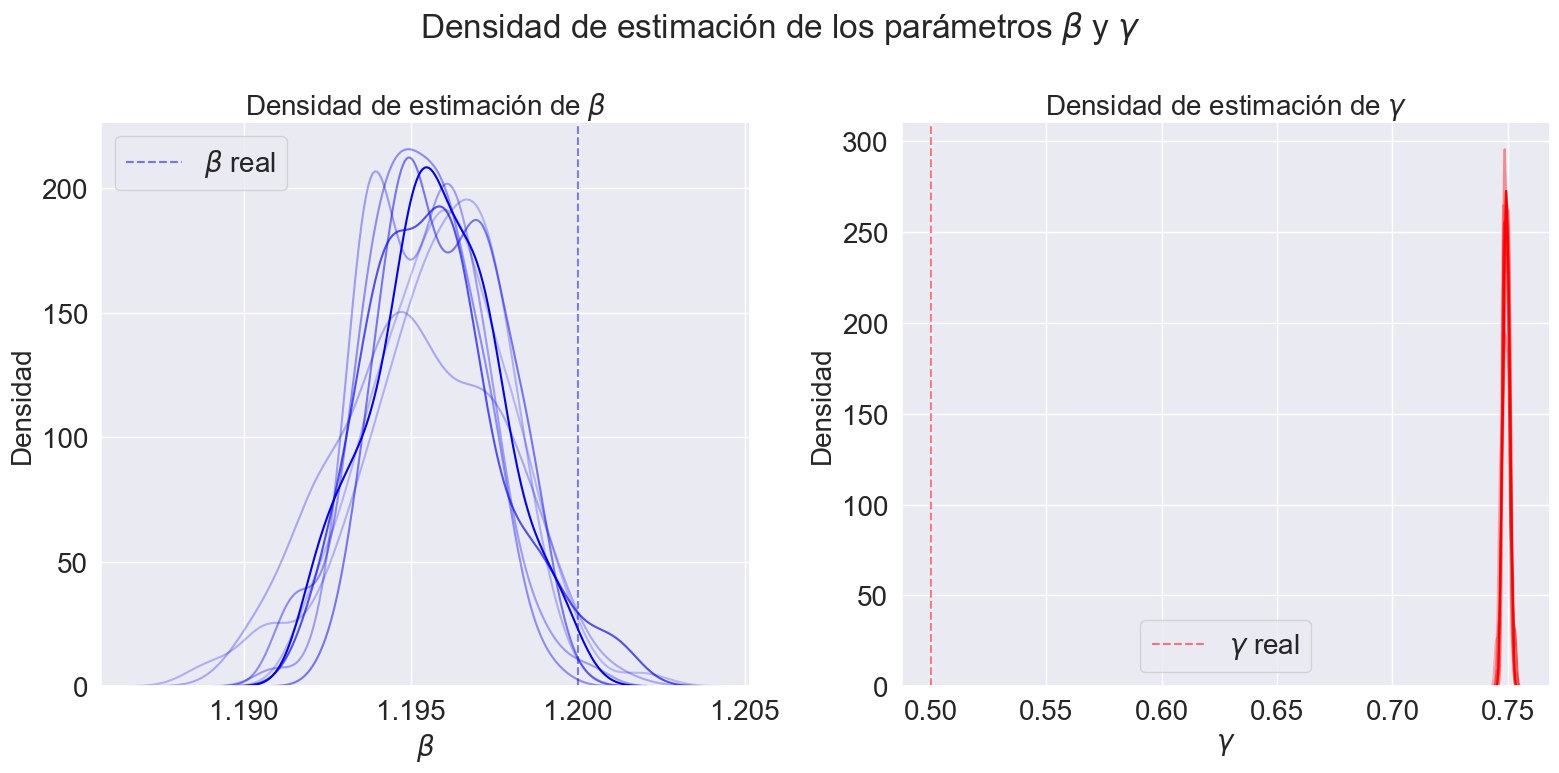

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.2, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\beta$ y $\gamma$, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_rec_params_density.pdf')

In [82]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        alpha*R-beta*S*I,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha = 0.2
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], alpha, beta, gamma)
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [83]:
def rhs_pymcode(y, t, p):
    dS_dt = p[0]*y[2]-p[1]*y[0]*y[1]
    dI_dt = p[1]*y[0]*y[1] - p[2]*y[1]
    dR_dt = p[2]*y[1]-p[0]*y[2]
    return [dS_dt, dI_dt, dR_dt]

In [84]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=np.arange(iters), n_states=3, n_theta=3, t0=0
)

In [85]:
theta = [0.1, 0.1, 0.1]

with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.01, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # ode_solution
    ode_solution = ode_model(y0=[0.9, 0.1, 0.0], theta=[alpha, beta, gamma])[:, :2]

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=y.T)

In [ ]:
np.random.seed(42)

sampler = "NUTS PyMC ODE"
tune = draws = 10
time_nuts = time()
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, chains=8, cores=8)
time_nuts = time() - time_nuts

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, beta, gamma, sigma]


Output()

In [ ]:
trace = trace_pymc_ode
az.summary(trace)

In [ ]:
print(f"Tiempo de ejecución: {time_nuts:.2f} s")

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

for i in range(8):
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["beta"][i], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(trace.posterior["gamma"][i], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(1.2, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(0.5, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\beta$ y $\gamma$, NUTS')
plt.tight_layout()
plt.savefig(img_path+'NUTS_sir_rec_params_density.pdf')